# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=60,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_16-36-41/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5197 | MulticlassF1Score=0.1390
Batch-30 : CrossEntropyLoss=2.4552 | MulticlassF1Score=0.2102
Batch-45 : CrossEntropyLoss=2.4179 | MulticlassF1Score=0.2901
Batch-60 : CrossEntropyLoss=2.4143 | MulticlassF1Score=0.3426
Batch-75 : CrossEntropyLoss=2.4082 | MulticlassF1Score=0.3774
Batch-90 : CrossEntropyLoss=2.4202 | MulticlassF1Score=0.4011
Batch-105: CrossEntropyLoss=2.3802 | MulticlassF1Score=0.4206
Batch-120: CrossEntropyLoss=2.3732 | MulticlassF1Score=0.4418
Batch-135: CrossEntropyLoss=2.3482 | MulticlassF1Score=0.4644
Batch-150: CrossEntropyLoss=2.3568 | MulticlassF1Score=0.4842
Batch-165: CrossEntropyLoss=2.3412 | MulticlassF1Score=0.5009
Batch-180: CrossEntropyLoss=2.3502 | MulticlassF1Score=0.5152
Batch-195: CrossEntropyLoss=2.3484 | MulticlassF1Score=0.5270
Batch-210: CrossEntropyLoss=2.3527 | MulticlassF1Score=0.5378
Batch-225: CrossEntropyLoss=2.3473 | MulticlassF1Score=0.5462
Batch-226: CrossEntropyLoss=2.3425 | MulticlassF1Score=0.5466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3394 | MulticlassF1Score=0.6674
Batch-30 : CrossEntropyLoss=2.3437 | MulticlassF1Score=0.6710
Batch-45 : CrossEntropyLoss=2.3554 | MulticlassF1Score=0.6723
Batch-60 : CrossEntropyLoss=2.3612 | MulticlassF1Score=0.6713
Batch-63 : CrossEntropyLoss=2.3359 | MulticlassF1Score=0.6719

Training   : Mean CrossEntropyLoss = 2.3999 | Mean MulticlassF1Score = 0.3983
Validation : Mean CrossEntropyLoss = 2.3507 | Mean MulticlassF1Score = 0.6703

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3477 | MulticlassF1Score=0.6657
Batch-30 : CrossEntropyLoss=2.3588 | MulticlassF1Score=0.6654
Batch-45 : CrossEntropyLoss=2.3443 | MulticlassF1Score=0.6692
Batch-60 : CrossEntropyLoss=2.3519 | MulticlassF1Score=0.6709
Batch-75 : CrossEntropyLoss=2.3473 | MulticlassF1Score=0.6726
Batch-90 : CrossEntropyLoss=2.3411 | MulticlassF1Score=0.6786
Batch-105: CrossEntropyLoss=2.3236 | MulticlassF1Score=0.6875
Batch-120: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.6978
Batch-135: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.7080
Batch-150: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7163
Batch-165: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7224
Batch-180: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7281
Batch-195: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7325
Batch-210: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7368
Batch-225: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7404
Batch-226: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7892
Batch-30 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7918
Batch-45 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7903
Batch-60 : CrossEntropyLoss=2.3283 | MulticlassF1Score=0.7897
Batch-63 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7893

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3289 | Mean MulticlassF1Score = 0.6971
Validation : Mean CrossEntropyLoss = 2.3141 | Mean MulticlassF1Score = 0.7894

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7955
Batch-30 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7943
Batch-45 : CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7913
Batch-60 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.7915
Batch-75 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7917
Batch-90 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7920
Batch-105: CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7906
Batch-120: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7921
Batch-135: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7924
Batch-150: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7924
Batch-165: CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7921
Batch-180: CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7921
Batch-195: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7924
Batch-210: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7928
Batch-225: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.7932
Batch-226: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8006
Batch-30 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8018
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8029
Batch-60 : CrossEntropyLoss=2.3191 | MulticlassF1Score=0.8014
Batch-63 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8019

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3120 | Mean MulticlassF1Score = 0.7927
Validation : Mean CrossEntropyLoss = 2.3102 | Mean MulticlassF1Score = 0.8031

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8143
Batch-30 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8094
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8090
Batch-60 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.8075
Batch-75 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.8057
Batch-90 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8057
Batch-105: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8053
Batch-120: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8064
Batch-135: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.8066
Batch-150: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8072
Batch-165: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8071
Batch-180: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8072
Batch-195: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8068
Batch-210: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8085
Batch-225: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8097
Batch-226: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8098

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8268
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8243
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8245
Batch-63 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3067 | Mean MulticlassF1Score = 0.8080
Validation : Mean CrossEntropyLoss = 2.3024 | Mean MulticlassF1Score = 0.8255

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8336
Batch-30 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8336
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8306
Batch-60 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8319
Batch-75 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8314
Batch-90 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8300
Batch-105: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8306
Batch-120: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8298
Batch-135: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8303
Batch-150: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8305
Batch-165: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8304
Batch-180: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8300
Batch-195: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8306
Batch-210: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8303
Batch-225: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8298
Batch-226: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8221
Batch-30 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8212
Batch-45 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8258
Batch-60 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8273
Batch-63 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8308
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8239

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8329
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8343
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8338
Batch-60 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8346
Batch-75 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8333
Batch-90 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8329
Batch-105: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8320
Batch-135: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8323
Batch-150: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8324
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8325
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8329
Batch-195: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8333
Batch-210: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8327
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8320
Batch-226: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8227
Batch-30 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8238
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8283
Batch-63 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8329
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8250

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8379
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8343
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8370
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8377
Batch-75 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8372
Batch-90 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8377
Batch-105: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8366
Batch-120: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8352
Batch-135: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8357
Batch-150: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8360
Batch-165: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8362
Batch-180: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8359
Batch-195: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8364
Batch-210: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8372
Batch-225: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8367
Batch-226: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8340
Batch-30 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8355
Batch-45 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8368
Batch-60 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8357
Batch-63 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8361
Validation : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8349

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8451
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8459
Batch-45 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8449
Batch-60 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8459
Batch-75 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8476
Batch-90 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8488
Batch-105: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8501
Batch-120: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8510
Batch-135: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8516
Batch-150: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8524
Batch-165: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8525
Batch-180: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8532
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8538
Batch-210: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8540
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8541
Batch-226: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8542

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8555
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8559
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8547
Batch-60 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8551
Batch-63 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8544

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2929 | Mean MulticlassF1Score = 0.8499
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8549

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8636
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8715
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8750
Batch-60 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8779
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8782
Batch-90 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8789
Batch-105: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8798
Batch-120: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8807
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8816
Batch-150: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8822
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8827
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8832
Batch-195: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8834
Batch-210: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8837
Batch-225: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8838
Batch-226: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8838

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8838
Batch-63 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8835

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8784
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8856

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8925
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8910
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8893
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8893
Batch-90 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8906
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8898
Batch-135: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8894
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8896
Batch-165: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8900
Batch-180: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8902
Batch-195: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8901
Batch-210: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8900
Batch-225: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8899
Batch-226: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8900

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8833
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8844
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8839

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8905
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8850

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8923
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8927
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8944
Batch-75 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8943
Batch-90 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8943
Batch-105: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8939
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8931
Batch-150: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8925
Batch-165: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8926
Batch-180: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8922
Batch-195: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8922
Batch-210: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8924
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8922
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8922

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8787
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8851
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8856
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8930
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8831

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9082
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9104
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9144
Batch-75 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9146
Batch-90 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9143
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9148
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9147
Batch-135: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9151
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9151
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9156
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9156
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9158
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9159
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9158
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9158

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9069
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9082
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9098
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9087
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9083

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9137
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9073

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9189
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9188
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9186
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9186
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9185
Batch-135: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9189
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9191
Batch-165: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9196
Batch-180: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9194
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9192
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9193
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9191
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9191

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9119
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9118
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9115

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9195
Validation : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9112

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9230
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9236
Batch-90 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9237
Batch-105: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9234
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9232
Batch-135: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9233
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9236
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9238
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9240
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9234
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9228
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9231
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9231

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9134
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9143
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9130
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9238
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9128

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9234
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9236
Batch-90 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9236
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9238
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9240
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9239
Batch-150: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9238
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9242
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9241
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9240
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9241
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9244
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9244

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9159
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9239
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9152

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9225
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9230
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9230
Batch-105: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9236
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9236
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9246
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9246
Batch-165: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9249
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9249
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9250
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9251
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9252
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9252

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9154
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9233
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9148

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9273
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9274
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9280
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9276
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9273
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9265
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9266
Batch-165: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9265
Batch-180: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9264
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9264
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9265
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9265
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9265

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9183
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9160
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9169
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9168

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9273
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9177

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9290
Batch-75 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9279
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9281
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9279
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9280
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9286
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9287
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9288
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9286
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9288
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9286
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9284
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9284

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9209
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9166
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9286
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9186

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9296
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9296
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9299
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9307
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9313
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9310
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9313
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9315
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9316
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9320
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9321
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9321
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9177
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9187
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9306
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9181

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9347
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9342
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9343
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9343
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9342
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9348
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9347
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9345
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9346
Batch-180: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9341
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9341
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9342
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9342
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9342

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9349
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9218

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9357
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9356
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9349
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9353
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9355
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9352
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9354
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9358
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9357
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9358
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9358
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9357

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9355
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9212

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9374
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9370
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9369
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9369
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9369
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9366
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9366

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9214
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9219

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9386
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9378
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9374
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9374

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9208
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9215

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9386
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9202

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9371
Batch-105: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9379
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9384
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9224
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9207

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9393
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9390
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9220

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9220
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9395
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9402
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9213

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9407
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9401
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9397
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9407
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9215

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9395
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9392
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9401
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9407
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9426

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9642
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9622
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9621
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9619
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9617
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9616
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9616
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9616
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9616
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9615
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9615
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9616
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9616
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9616

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9453
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9451

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9620
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9456

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9638
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9635
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9634
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9635
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9450

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9450

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9617
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9636
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9642
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9642
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9646
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9641
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9474

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9646
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9656
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9654
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9468

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9660
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9478

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9671
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9486

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9455

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9673
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9474
Patience = 2/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9465

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9461

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9522
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9486

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9487

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9535
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9499

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9510
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9503
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9511

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9724
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9708
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9524
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9504
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9499

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9507

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9467

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9730
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9724
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9523
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9501
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9502

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9507

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9742
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9728
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9729
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9723
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9718
Batch-135: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9500
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9503

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9481
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9720
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9713
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9500

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9496

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9725
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9718
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9494

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9503
Patience = 4/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9715
Best MulticlassF1Score validation : 0.9496
Training duration                 : 1.9589 minutes.
Training date                     : 2022-10-19 11:20:49.716598+08:00


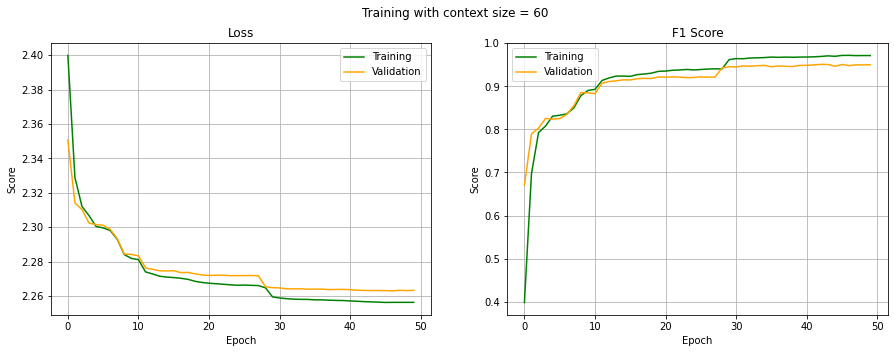

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9493, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9714, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9493, device='cuda:0'))

## Heatmap

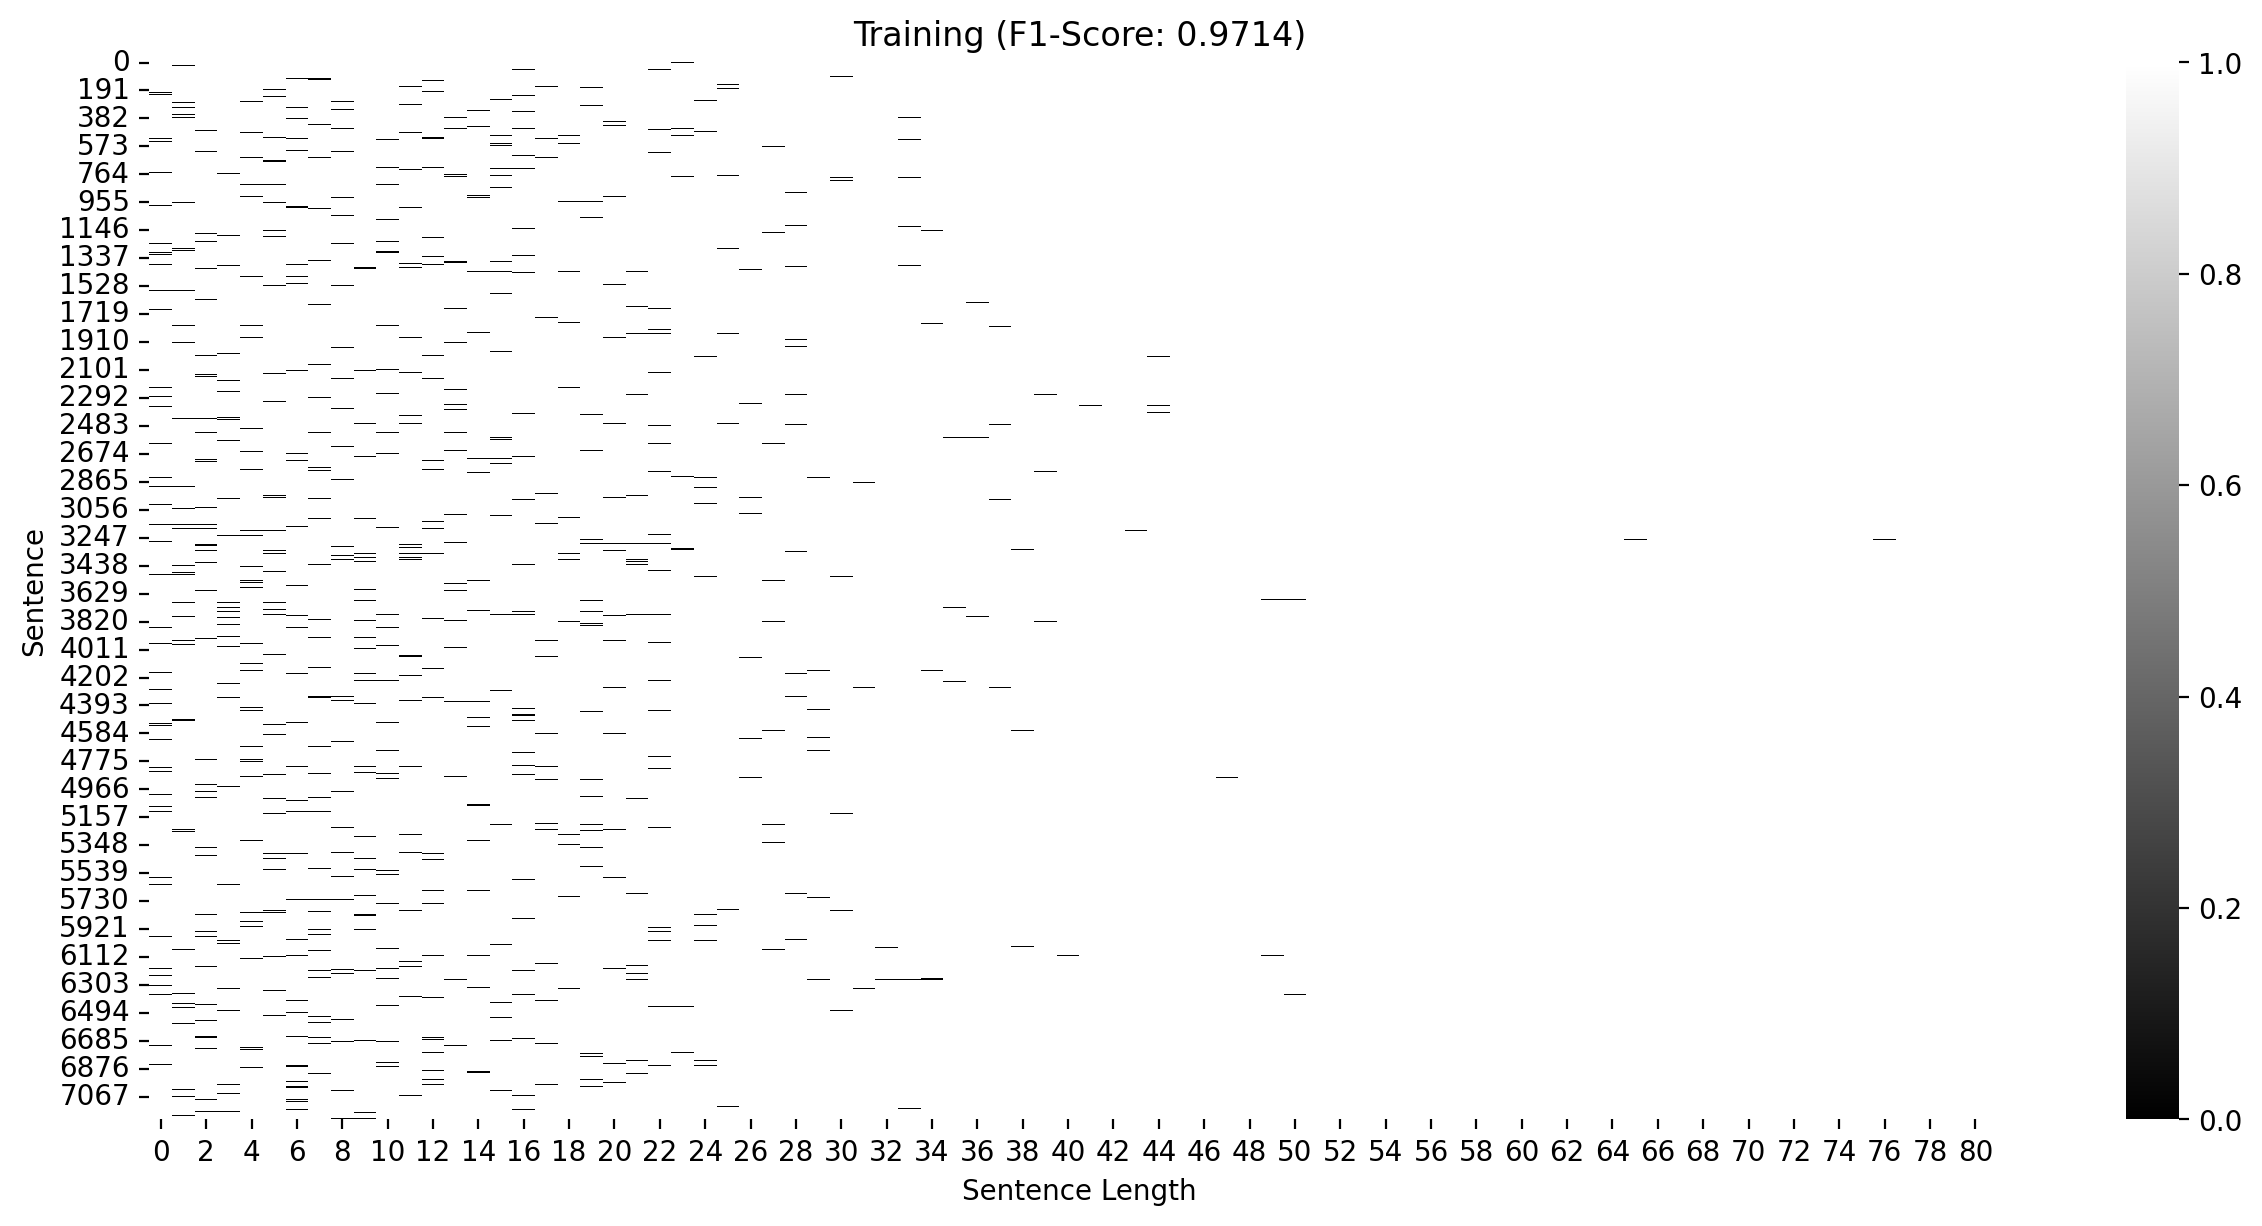

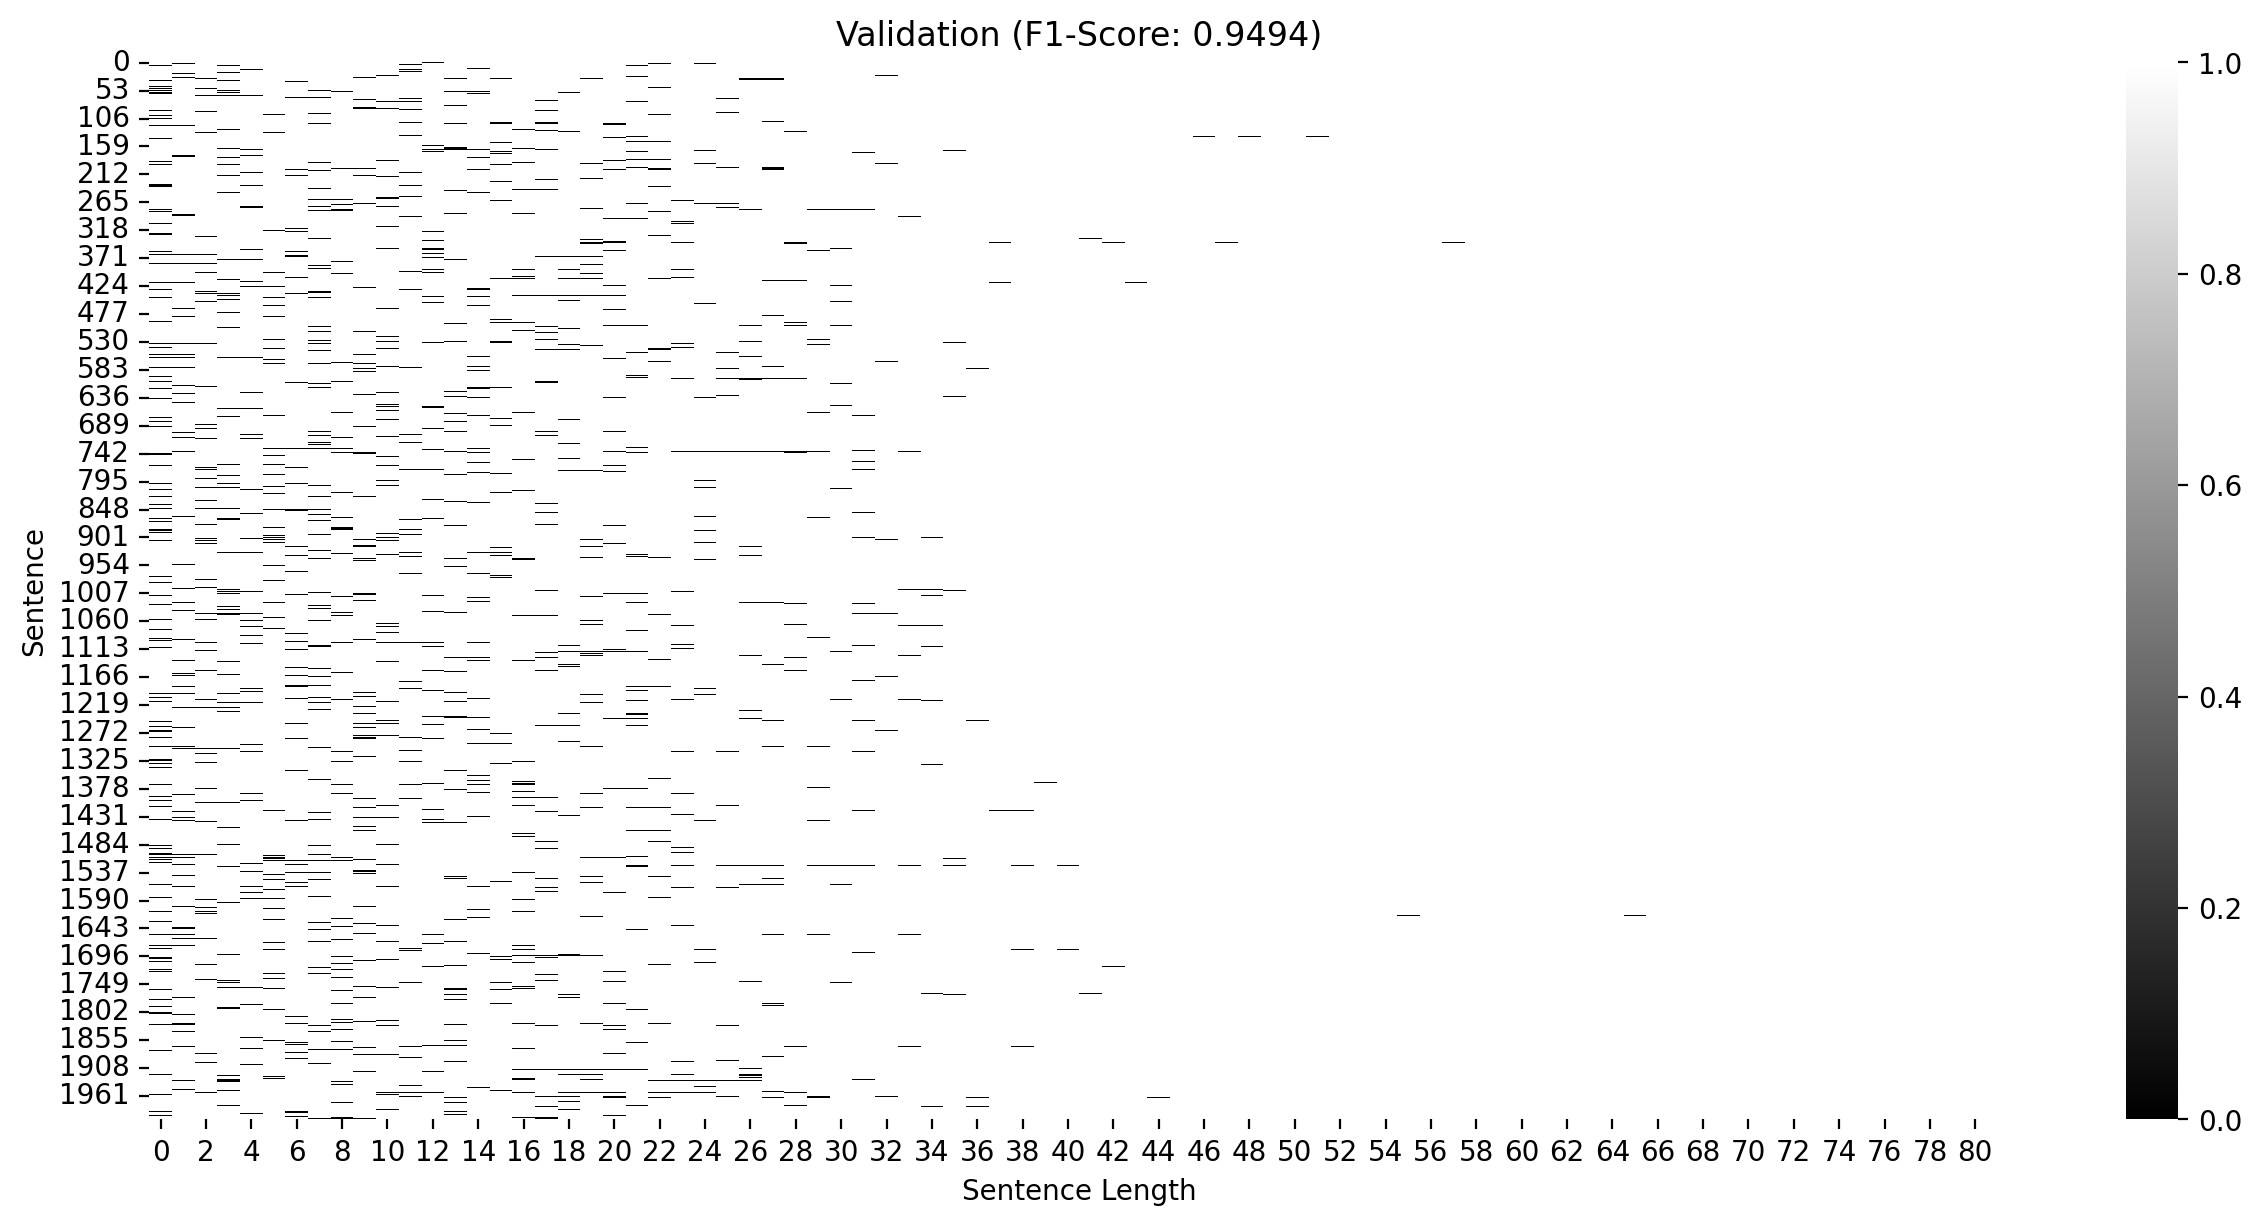

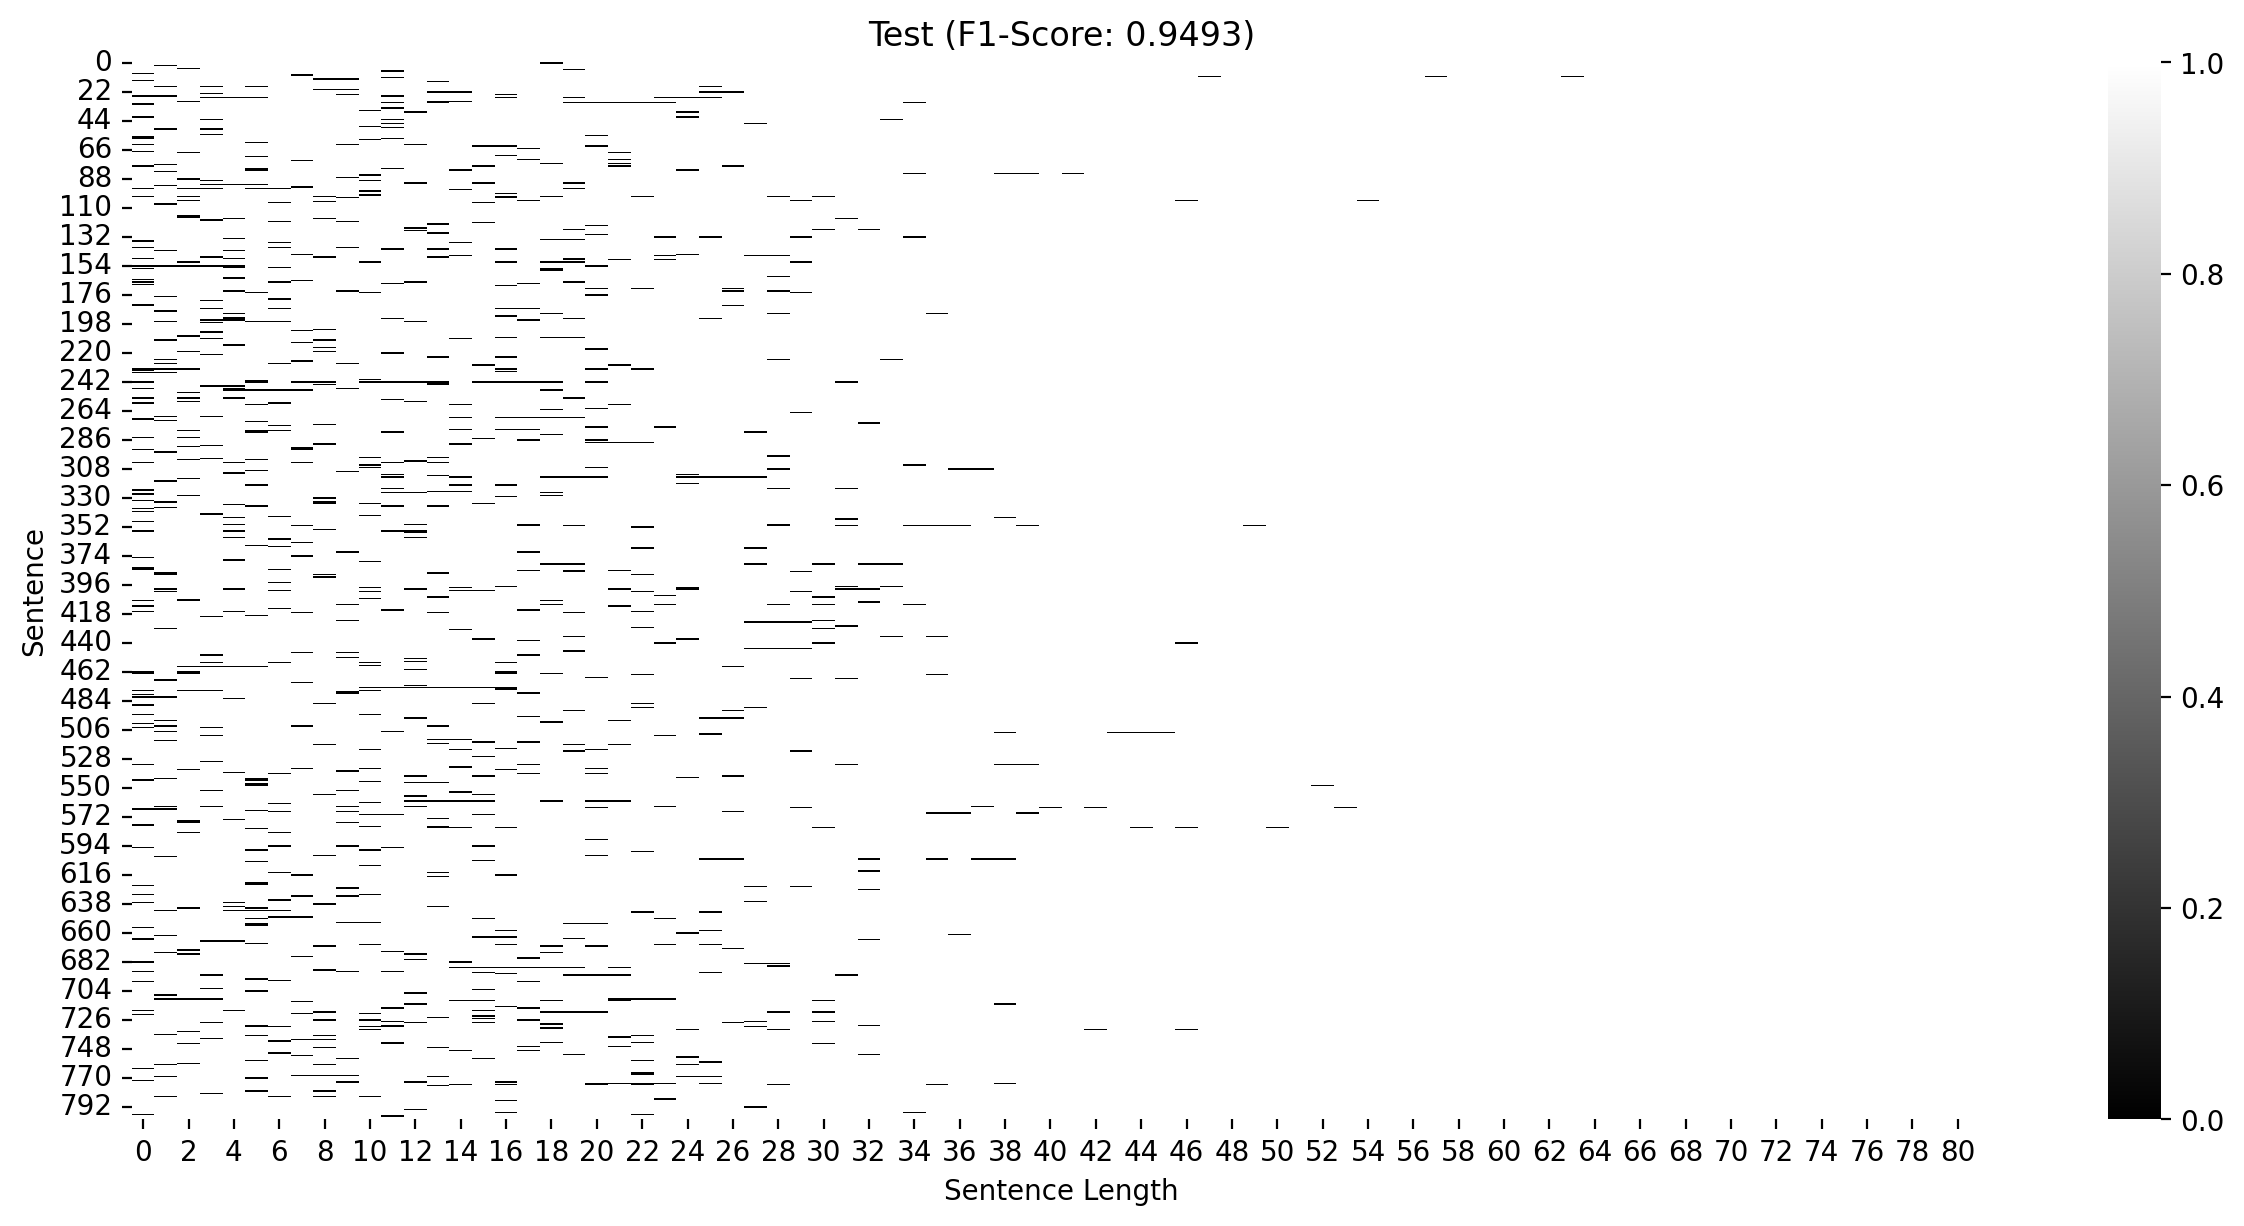

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


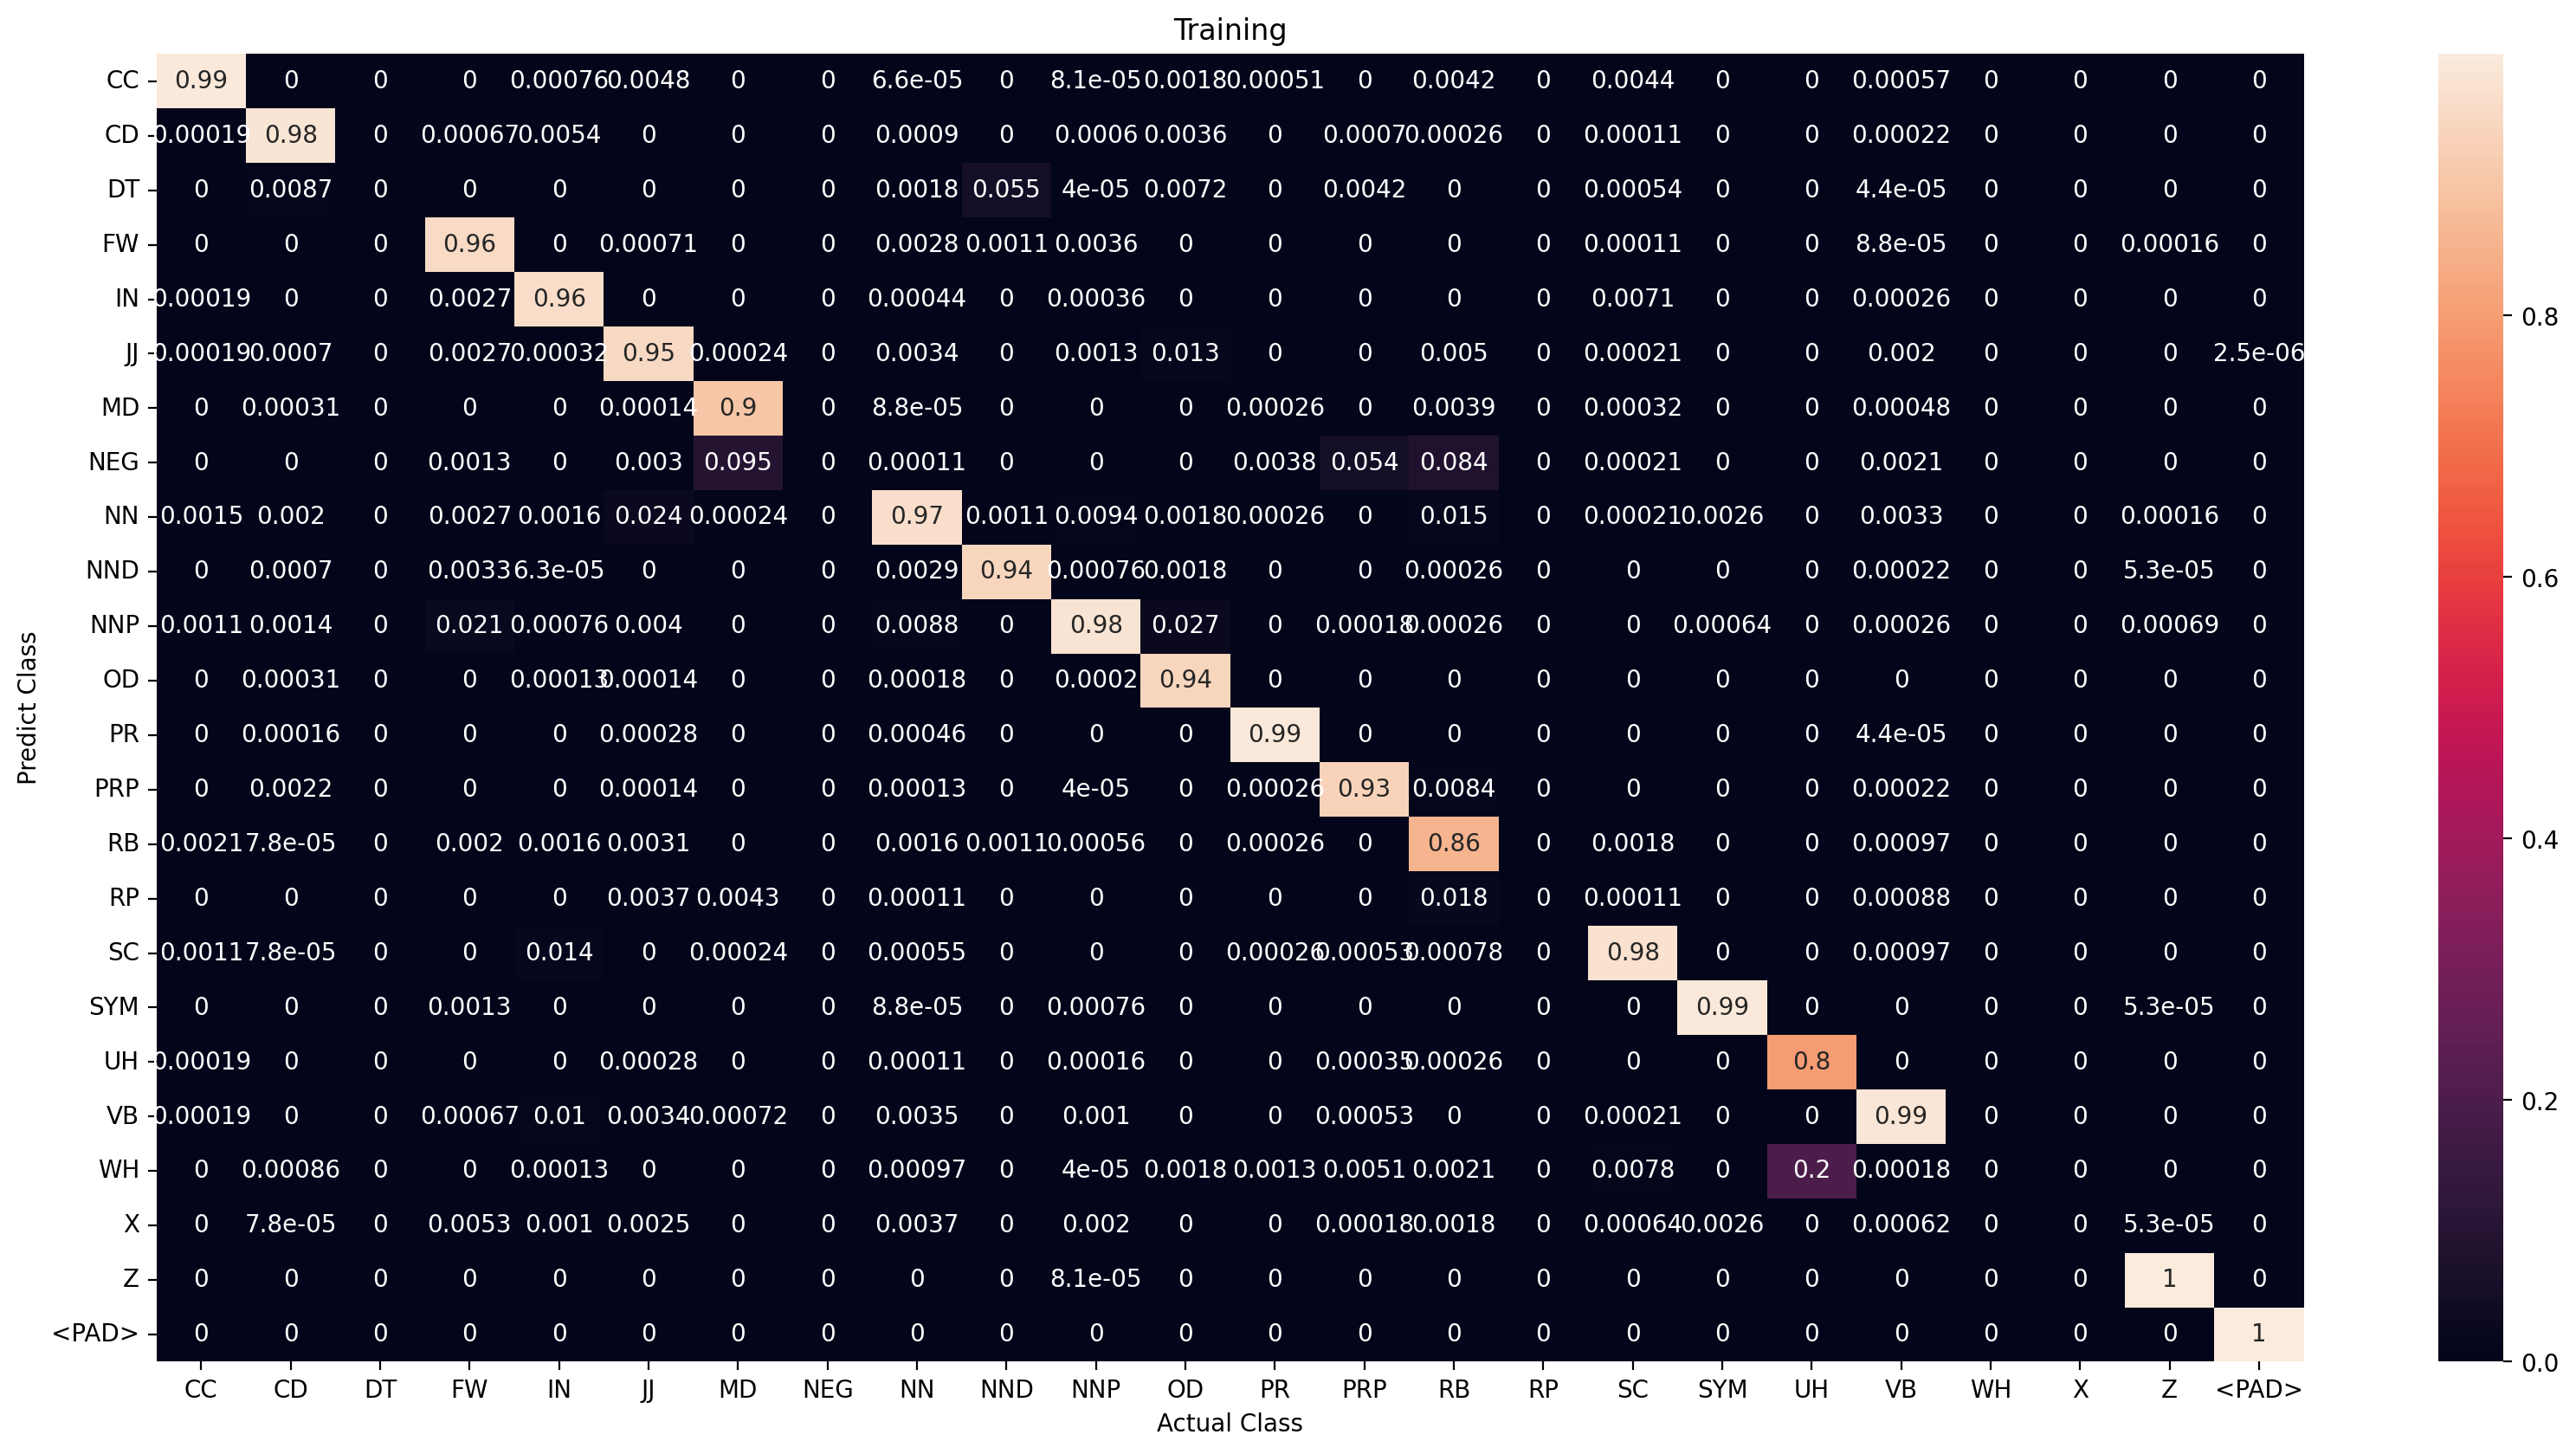

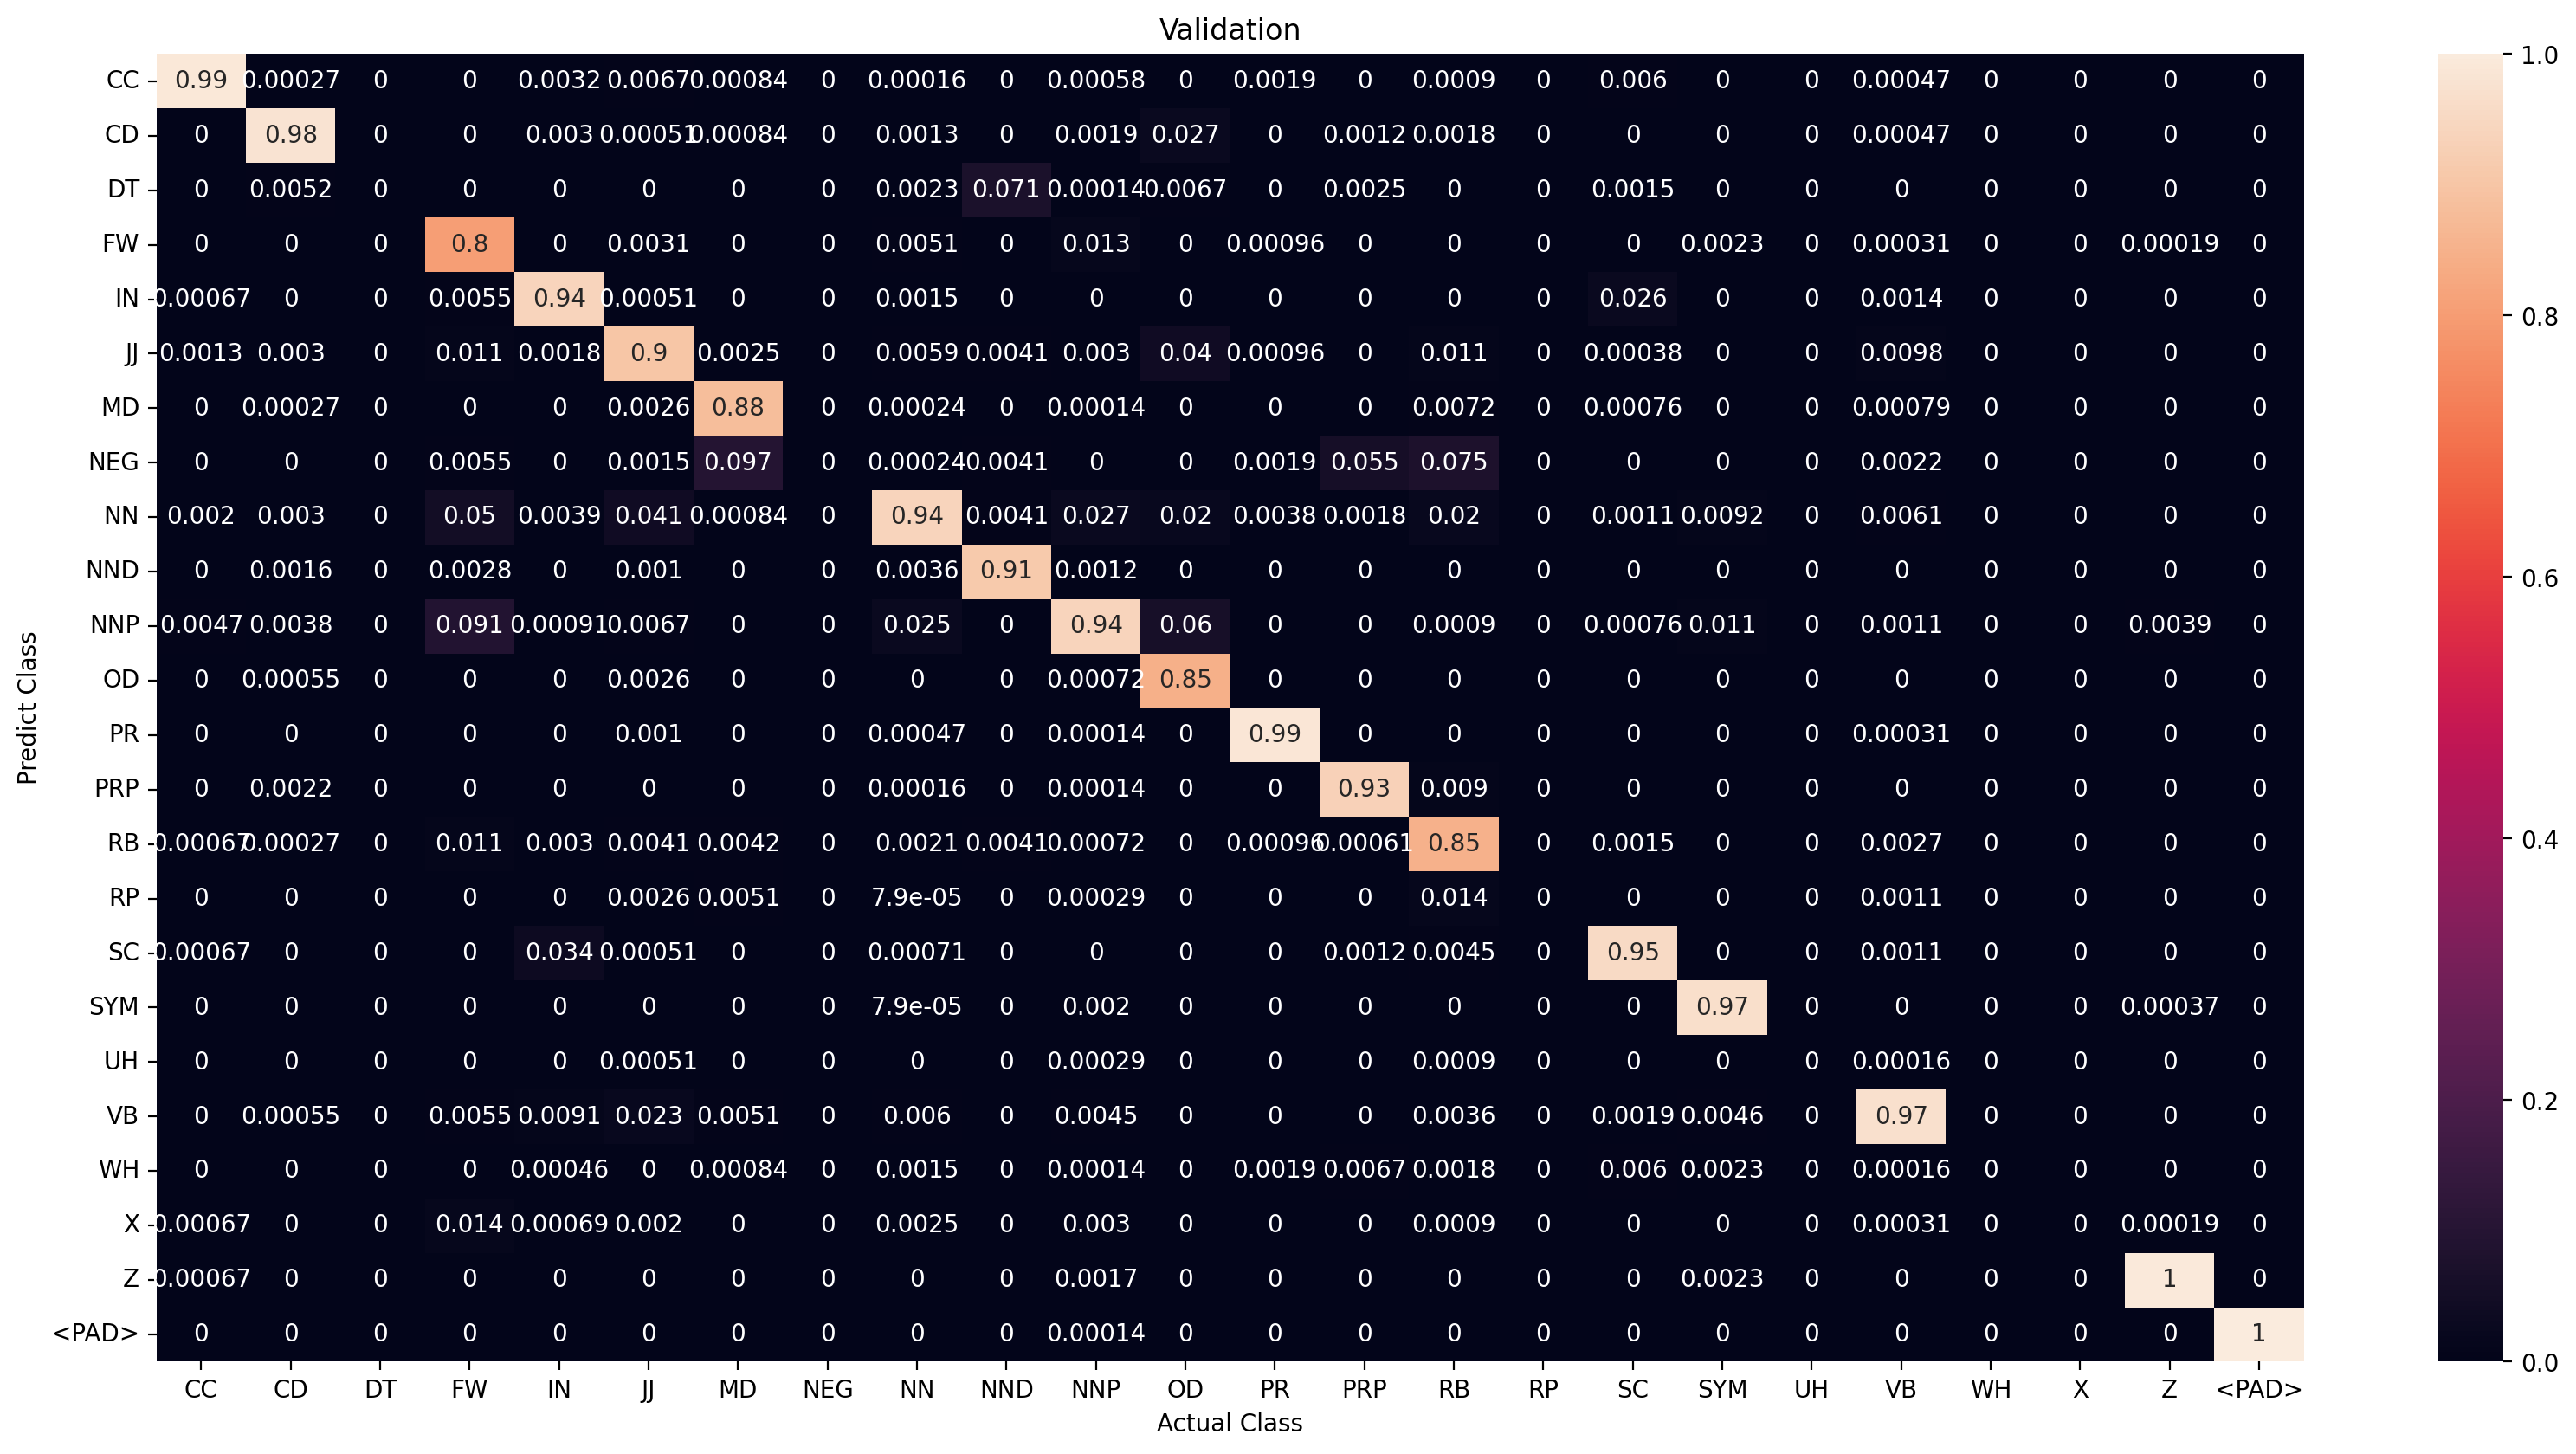

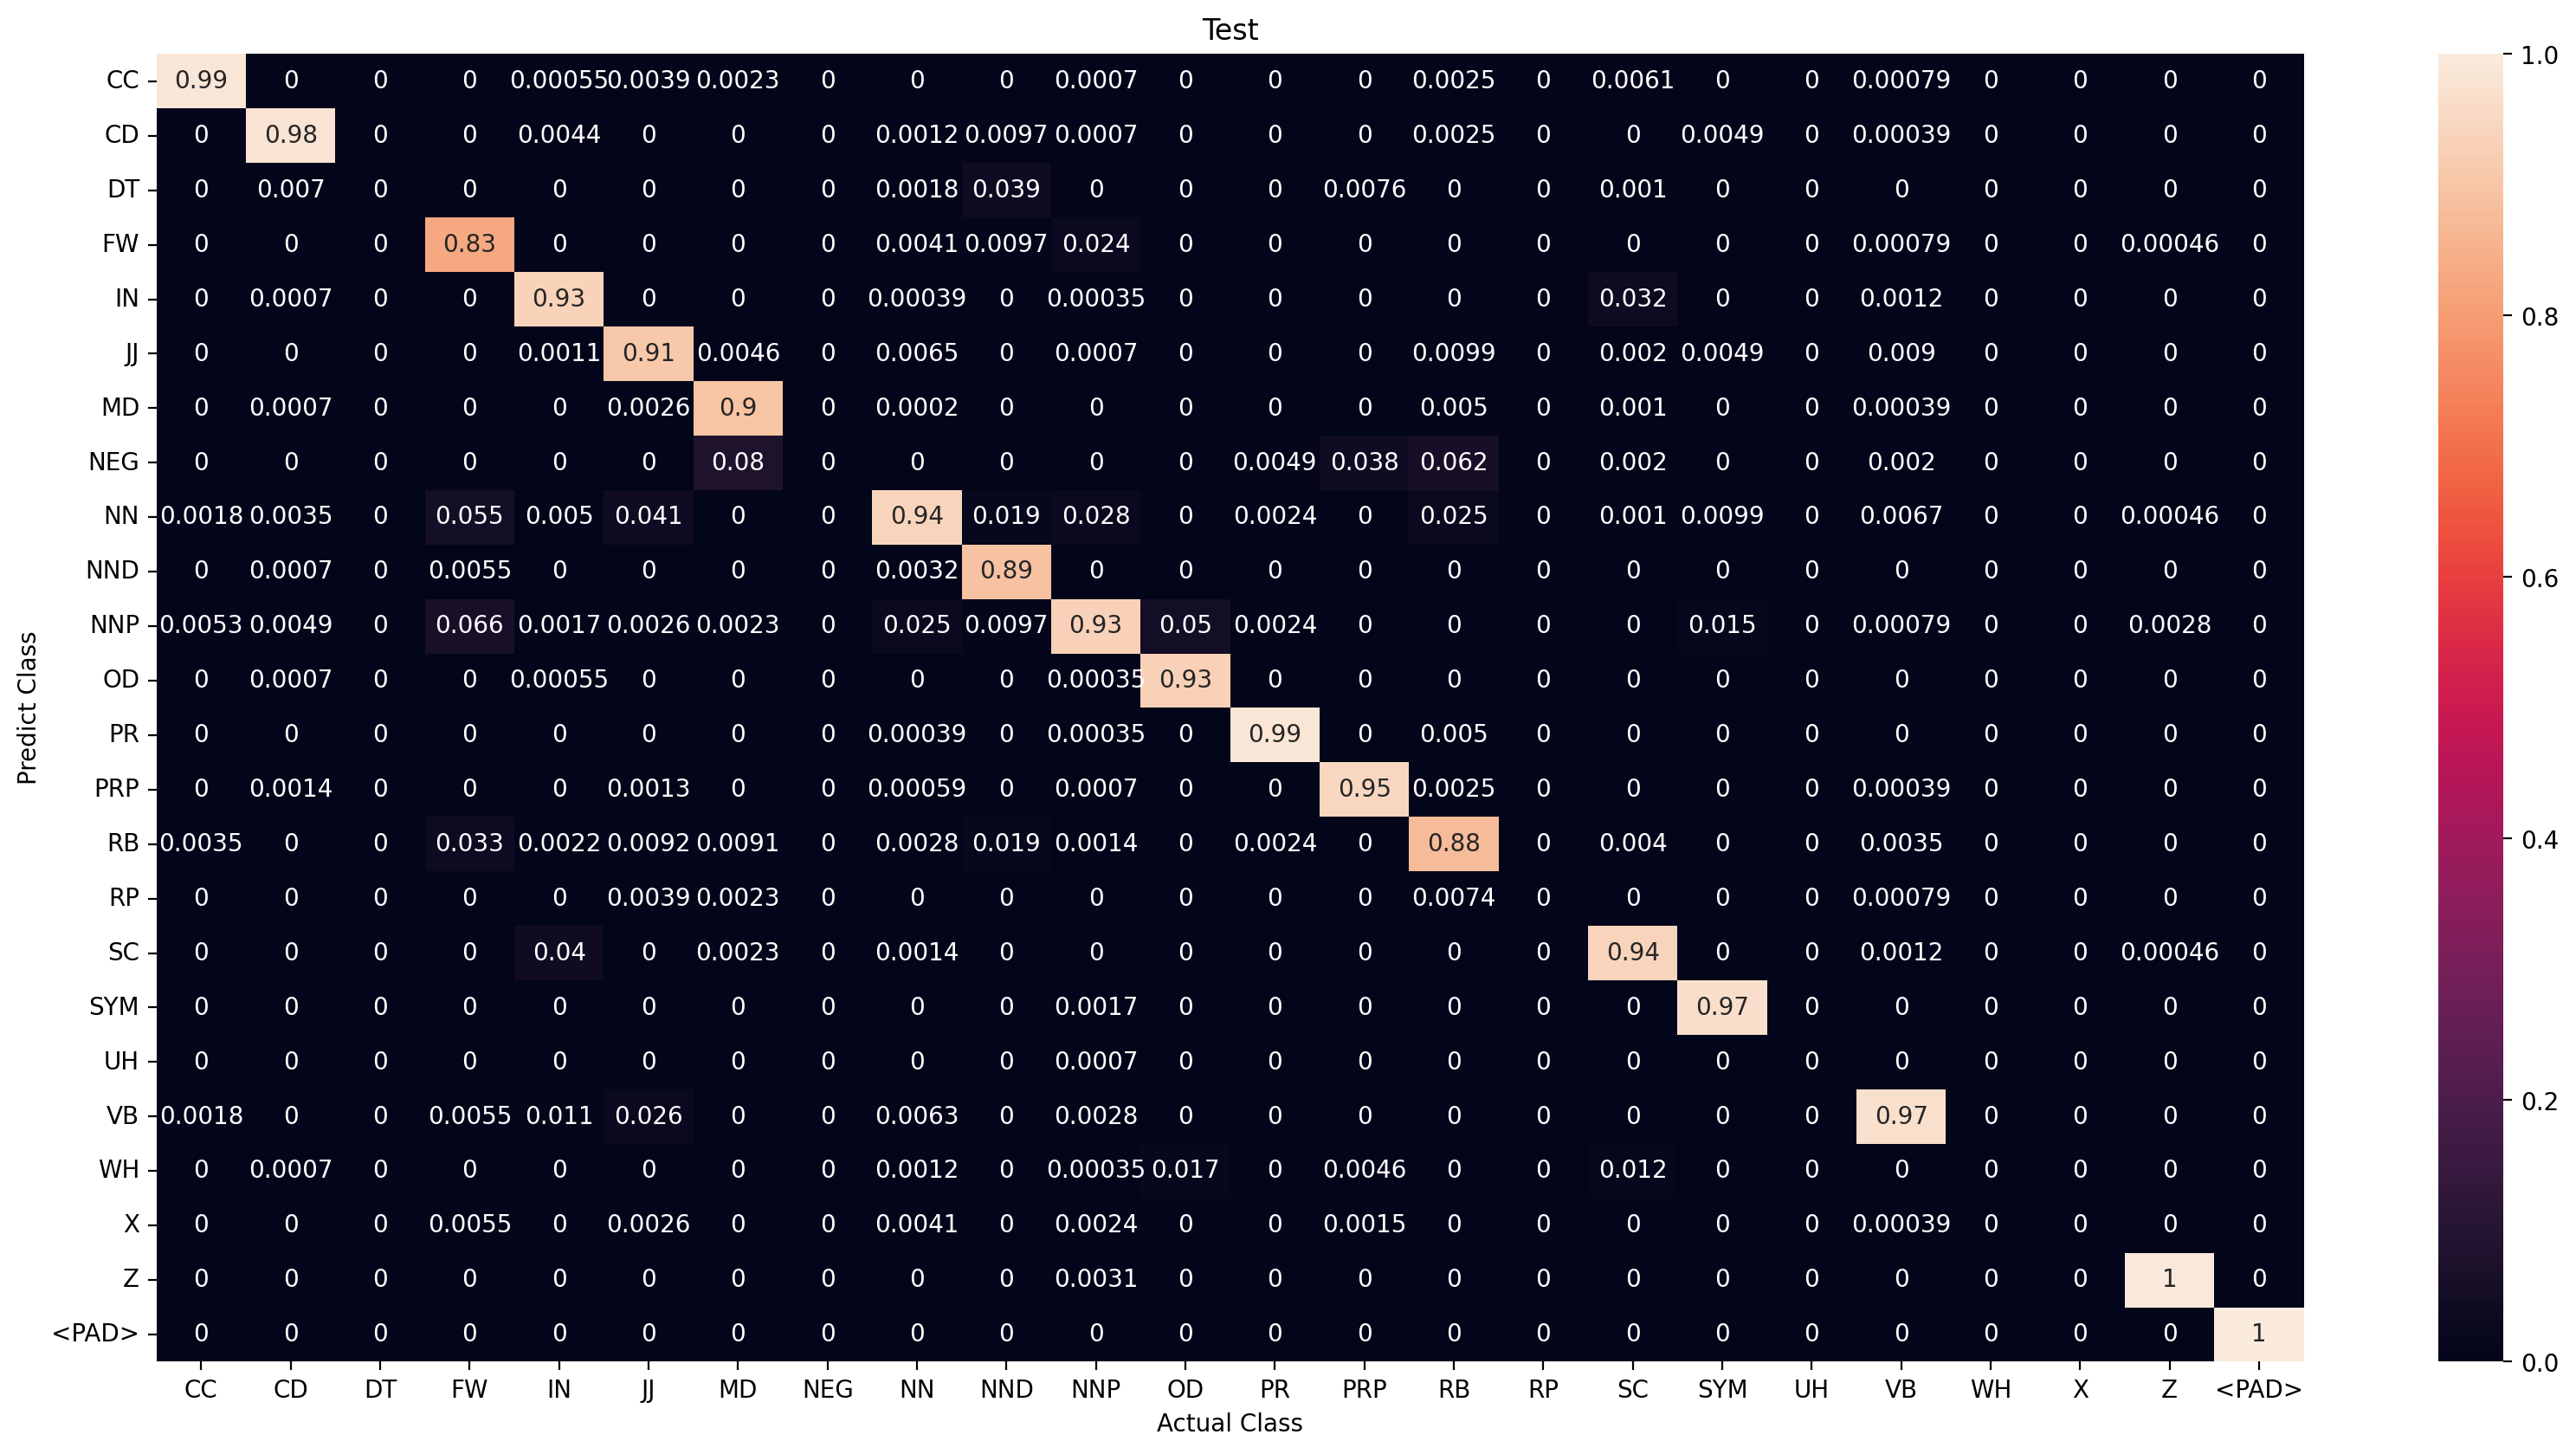

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5198       | CC    : 124      |
| CD    : 12758  | CD    : 12601      | CD    : 157      |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1437       | FW    : 229      |
| IN    : 15371  | IN    : 15265      | IN    : 106      |
| JJ    : 6997   | JJ    : 6713       | JJ    : 284      |
| MD    : 3774   | MD    : 3735       | MD    : 39       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44058      | NN    : 614      |
| NND   : 1021   | NND   : 845        | NND   : 176      |
| NNP   : 24845  | NNP   : 24314      | NNP   : 531      |
| OD    : 541    | OD    : 521        | OD    : 20       |
| PR    : 3896   | PR    : 3870       | PR    : 26       |
| PRP   : 5408   | PRP   : 5334       | PRP   : 74       |
| RB    : 3463   | RB    : 3274       | RB    : 189      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11177
Wrong prediction            : 644
Percentage correct oov pred : 94.55206835293123

Validation
Number OOV token            : 3350
Correct prediction          : 2983
Wrong prediction            : 367
Percentage correct oov pred : 89.04477611940298

Test
Number OOV token            : 1391
Correct prediction          : 1253
Wrong prediction            : 138
Percentage correct oov pred : 90.07907979870596



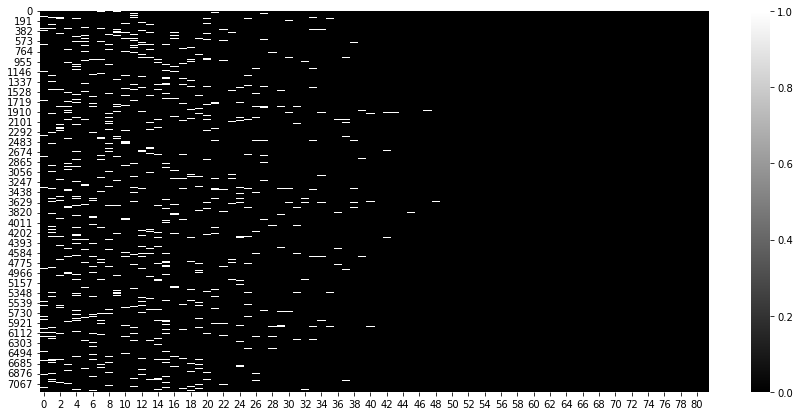

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

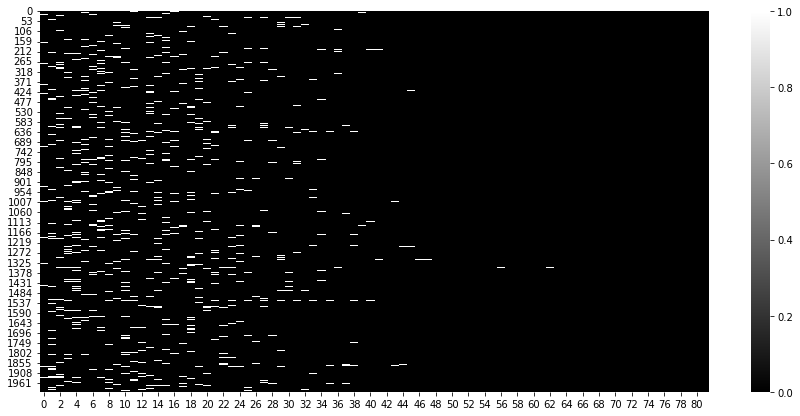

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

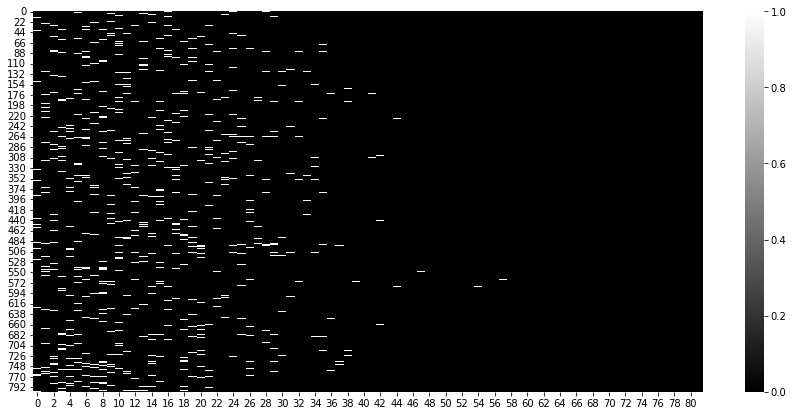

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);